In [27]:
import aplpy
import os
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.convolution import convolve_fft, Gaussian2DKernel
import math 
from astropy import units as u
from scipy.interpolate import UnivariateSpline
import scipy.optimize as optimize
from scipy.interpolate import interp1d
import sys
from numpy.random import rand,seed
from pylab import *
from scipy import stats
from lmfit import Minimizer, Parameters, report_fit

In [33]:
#LOADING IN DATA FILES
after_B1_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/n_dens_pbcor/N_dens_feather10_B1_000_clean14_1_pbcor.fits')
before_B1_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/N_dens/N_dens_B1snap_000.fits')
after_B1_051 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/n_dens_pbcor/N_dens_feather10_B1_051_clean14_pbcor.fits')
before_B1_051 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/N_dens/N_dens_B1snap_051.fits')
after_B10_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/n_dens_pbcor/N_dens_feather10_B10_000_clean14_pbcor.fits')
before_B10_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/N_dens/N_dens_B10snap_000.fits')
after_B10_066 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/n_dens_pbcor/N_dens_feather10_B10_066_clean14_pbcor.fits')
before_B10_066 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/N_dens/N_dens_B10snap_066.fits')
noise_B1_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/flux10_noise_final/flux10_B1snap_000_clean14_1_noise_finalfwhm.fits')
noise_B1_051 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/flux10_noise_final/flux10_B1snap_051_clean14_noise_finalfwhm.fits')
noise_B10_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/flux10_noise_final/flux10_B10snap_000_clean14_noise_finalfwhm.fits')
noise_B10_066 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/flux10_noise_final/flux10_B10snap_066_clean14_noise_finalfwhm.fits')

In [34]:
#SIMULATED OBSERVATIONAL DATA
def simulated_data_retrieval(sim_self):
    sim_self = sim_self[0].data
    column_density_array_after = sim_self
    flat_column_density_array_after = column_density_array_after.flatten()
    return flat_column_density_array_after

In [35]:
#ORIGINAL SIMULATION DATA
def original_data_retrieval(snap_self):
    snap_self = snap_self[0].data * 10
    column_density_array_before = snap_self / (1e4)
    flat_column_density_array_before = column_density_array_before.flatten()
    return flat_column_density_array_before

In [36]:
#COMBINING THESE FUNCTIONS
def data_harvesting(before_data, after_data):
    after_data_flat_array = simulated_data_retrieval(after_data)
    before_data_flat_array = original_data_retrieval(before_data)
    return before_data_flat_array, after_data_flat_array

In [37]:
#GETTING SIGMA DATA
def sigma_retrieval(noise_file):
    sigma_data = noise_file[0].data
    flat_sigma_data = sigma_data.flatten()
    sigma_value = np.median(flat_sigma_data)
    three_sigma_value = 3 * np.median(flat_sigma_data)
    return three_sigma_value

In [38]:
#SPLINE FITTING ROUTINE
def spline_method(x_data, y_data):
    spl = UnivariateSpline(x_data, (y_data), k = 1, s = .03)
    x_num_array = np.linspace(min(x_data), max(x_data), 500)
    deriv = spl.derivative(1)

    plt.plot(x_data, y_data, label = 'Data' )
    plt.plot(x_num_array, spl(x_num_array), label = 'Fit', linestyle = ':', color = 'red')
    plt.legend()
    plt.show()
    
    plt.plot(x_num_array, deriv(x_num_array), label = '1st Derivative')
    plt.xscale('log')
    plt.legend()
    plt.show()
    
    max_deriv = deriv(x_num_array)[1]
    x_min_value = x_num_array[np.argwhere(deriv(x_num_array) < max_deriv)][0]
    
    
    return x_min_value

In [39]:
#CREATING PLOTS OF DATA
def create_pdf(image_data, number_of_bins):
    image = np.log10(image_data)
    n_min = np.min(image)
    n_max = np.max(image)
    n_bins = number_of_bins
    n_total = np.count_nonzero(image)
    n_edges = np.linspace(n_min, n_max, n_bins)
    n_cens = [(a + b) /2 for a,b in zip(n_edges[:-1], n_edges[1:])]
    
    bin_width = n_edges[2] - n_edges[1]
    
    x_arr = np.array(n_cens)
    y_arr = np.zeros(n_bins)
    for i in range(n_bins -1):
        pix_in_bin_i = np.where((image>n_edges[i]) & (image<n_edges[i+1]))[0]
        y_arr[i] = np.array(np.count_nonzero(pix_in_bin_i) * ((n_total)**(-1)) * ((bin_width)**(-1)))
        
    normalization = y_arr * bin_width
    normalization_check = np.sum(normalization)
        
    return x_arr, y_arr, normalization_check

In [40]:
def plotting_pdf(image_data, number_of_bins):
    x_arr = create_pdf(image_data, number_of_bins)[0]
    y_arr = np.log10(create_pdf(image_data, number_of_bins)[1])
    plt.scatter(x_arr, y_arr[:-1])
    return x_arr, y_arr

In [41]:
#FITTING FUNCTION USING ONLY SPILKER EQ 6
def resid_log_powerlaw(avec, x, y):
    alpha, beta = avec
    R = np.zeros_like(x)
    R = (alpha*x) + beta - y
    return R

In [42]:
#CREATING FIT
def fit_powerlaw(afit, x):
    yfit = np.zeros_like(x)
    yfit = (afit[0]*x) + afit[1]
    return yfit

In [43]:
#PLOTTING FUNCTION FOR FINAL PDF WITH FITS
def final_plot(x_before, x_powerlaw_before, y_before, x_after, x_powerlaw_after, y_after):
    fig, ax = plt.subplots()
    ax.scatter(x_before, y_before[:-1], color = 'firebrick')
    ax.plot(x_powerlaw_before, (fit_powerlaw(afit_before, x_powerlaw_before)), color = 'firebrick', linestyle = ':', label = 'Before Observation and Cleaning')
    plt.axvline(x_min_before, label = r'', linestyle = ':', color = 'firebrick')
    ax.scatter(x_after, y_after[:-1], color = 'cornflowerblue')
    ax.plot(x_powerlaw_after, (fit_powerlaw(afit_after, x_powerlaw_after)), color = 'cornflowerblue', linestyle = ':', label = 'After Observation and Cleaning')
    plt.axvline(x_min_after, label = r'', linestyle = ':', color = 'cornflowerblue')
    plt.axvline(np.log10(sigma_retrieval(noise_B1_000)), label = r'3 $\sigma$', linestyle = ':', color = 'olive')
    plt.text(23.1, 0.5, r'$\alpha = $' + str(afit_before[0]), horizontalalignment = 'left', color = 'firebrick')
    plt.text(23.1, 0.3, r'$\alpha = $' + str(afit_after[0]), horizontalalignment = 'left', color = 'cornflowerblue')
    plt.xlabel('Column Density $\#/cm^2$')
    plt.ylabel('$Log_{10} Probability Density$')
    ax.set_title(title)
    fig.set_size_inches(10,7)
    plt.legend()
    plt.legend(loc = 'lower left')
    plt.show()

In [44]:
data_array_before, data_array_after_all = data_harvesting(before_B1_000, after_B1_000)
data_array_after = data_array_after_all[(data_array_after_all>1e22)]
noise_data = noise_B1_000
title = 'B1 000'

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


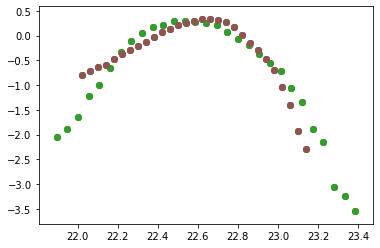

In [45]:
plotting_pdf(data_array_before, 30)
x_arr_before = plotting_pdf(data_array_before, 30)[0]
y_arr_before = plotting_pdf(data_array_before, 30)[1]
plotting_pdf(data_array_after, 30)
x_arr_after = plotting_pdf(data_array_after, 30)[0]
y_arr_after = plotting_pdf(data_array_after, 30)[1]

In [46]:
print(y_arr_before[:-1])

[-2.050877   -1.87948086 -1.6391487  -1.21385909 -0.99941326 -0.65014409
 -0.34084156 -0.11932071  0.04915986  0.16720088  0.21652185  0.28571184
  0.29547598  0.27842245  0.25364133  0.20888638  0.06628734 -0.06613197
 -0.19922419 -0.37640106 -0.54880246 -0.72072516 -1.050877   -1.33272367
 -1.88902618 -2.14429868 -3.06511743 -3.24120869 -3.54223869]


In [47]:
print(y_arr_after[:-1])

[-7.88661772e-01 -7.07174689e-01 -6.31843334e-01 -5.89370313e-01
 -4.77090130e-01 -3.75827810e-01 -3.00998871e-01 -2.14701647e-01
 -1.29912267e-01 -2.79281730e-02  7.34754707e-02  1.38680842e-01
  2.21150230e-01  2.63083159e-01  3.01841524e-01  3.29122389e-01
  3.24213205e-01  3.05379057e-01  2.65821409e-01  1.79235619e-01
  1.24448050e-03 -1.42742468e-01 -3.01346168e-01 -4.77611179e-01
 -6.90686005e-01 -1.03652834e+00 -1.40703011e+00 -1.93585818e+00
 -2.28431283e+00]


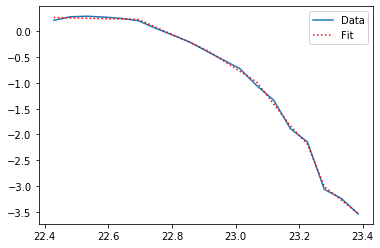

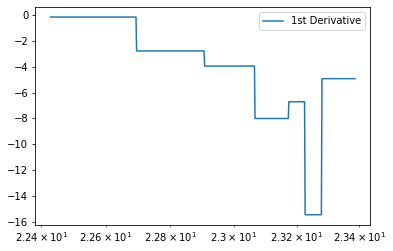

22.69507129174916


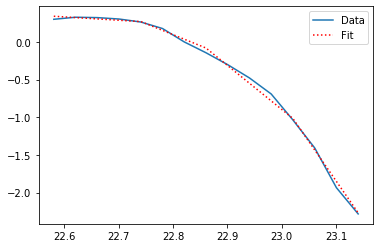

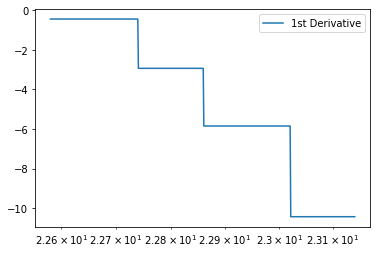

22.74110225414935


In [48]:
x_min_before = spline_method(x_arr_before[10:], y_arr_before[10:-1])[0]
print(x_min_before)

x_min_after = spline_method(x_arr_after[14:], y_arr_after[14:-1])[0]
print(x_min_after)

In [83]:
x_before_powerlaw_full = x_arr_before[(x_arr_before>x_min_before)]
x_before_powerlaw = x_before_powerlaw_full
print(len(x_before_powerlaw))
print(len(y_arr_before))
print(y_arr_before[16:-1])
print(len(y_arr_before[16:-1]))
y_before_powerlaw = y_arr_before[16:-1]

13
30
[ 0.06628734 -0.06613197 -0.19922419 -0.37640106 -0.54880246 -0.72072516
 -1.050877   -1.33272367 -1.88902618 -2.14429868 -3.06511743 -3.24120869
 -3.54223869]
13


In [50]:
x_after_powerlaw = x_arr_after[(x_arr_after>x_min_after)]
print(len(x_after_powerlaw))
print(len(y_arr_after))
print(y_arr_after[19:-1])
print(len(y_arr_after[19:-1]))
y_after_powerlaw = y_arr_after[19:-1]

10
30
[ 1.79235619e-01  1.24448050e-03 -1.42742468e-01 -3.01346168e-01
 -4.77611179e-01 -6.90686005e-01 -1.03652834e+00 -1.40703011e+00
 -1.93585818e+00 -2.28431283e+00]
10


In [51]:
#MAKING PARAMETER GUESSES AND RUNNING FUNCTION
alpha, beta = -2, 10
afit_before, flag_before = optimize.leastsq(resid_log_powerlaw, [alpha, beta], args = (x_before_powerlaw, y_before_powerlaw))
print(flag_before)
print(afit_before)
afit_after, flag_after = optimize.leastsq(resid_log_powerlaw, [alpha, beta], args = (x_after_powerlaw, y_after_powerlaw))
print(flag_after)
print(afit_after)

1
[ -5.94961203 135.84417182]
1
[ -6.73323408 153.79075081]


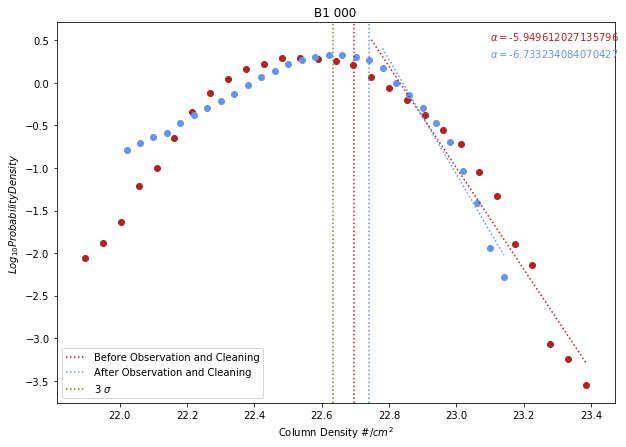

In [52]:
final_plot(x_arr_before, x_before_powerlaw, y_arr_before, x_arr_after, x_after_powerlaw, y_arr_after)

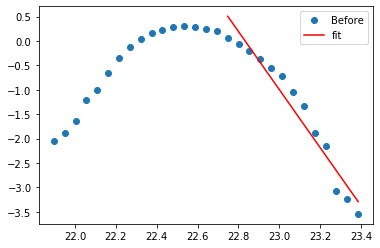

In [29]:
res = stats.linregress(x_before_powerlaw, y_before_powerlaw)
plt.plot(x_arr_before, y_arr_before[:-1], 'o', label='Before')
plt.plot(x_before_powerlaw, res.intercept + res.slope*x_before_powerlaw, 'r', label='fit')
plt.legend()
plt.show()

In [23]:
print(res.slope)
print(res.stderr)

-5.949612263693819
0.4316123357997002


In [208]:
#FITTING FUNCTION SIMILAR TO OLD METHOD USING SPILKER EQ 5 AND 6
def resid_log_piecewise(avec, x, y, b):
    A, sigma, mu, alpha, beta = avec
    R = np.zeros_like(x)
    cond1 = np.where(x<b)
    cond2 = np.where(x>b)
    R[cond1] = ((A)/((sigma)*np.sqrt(2*np.pi)*np.exp(x[cond1])))*np.exp((-(x[cond1]-mu)**2)/(2*sigma**2)) - y[cond1]
    R[cond2] = (alpha*x) + beta - y[cond2]
    return R

In [140]:
def fit_piecewise(afit, x):
    yfit = np.zeros_like(x)
    cond1 = np.where(x<afit[0])
    cond2 = np.where(x>=afit[0])
    yfit[cond1] = ((afit[0])/(afit[1]*np.sqrt(2*np.pi)*np.exp(x[cond1])*np.exp(x[cond1])))*np.exp((-(x[cond1]-afit[3])**2)/(2*afit[2]**2))
    yfit[cond2] = (afit[4]*x[cond2]) + afit[5]
    return yfit

In [144]:
A, sigma, mu, alpha, beta = 0.5, 1, 0.4, -5, 100
afit, flag = optimize.leastsq(resid_log_piecewise, [A, sigma, mu, alpha, beta], args = (x_arr[:-2], y_arr[:-3], x_min_before))
print(flag)
print(afit)

ValueError: operands could not be broadcast together with shapes (27,) (0,) 

In [57]:
def resid_log_piecewise_test(params, x, y, sigma):
    R = np.zeros_like(x)
    cond1 = np.where(x<b)
    cond2 = np.where(x>b)
    R[cond1] = ((params['amp'])/((sigma)*np.sqrt(2*np.pi)*np.exp(x[cond1])))*np.exp((-(x[cond1]-params['mu'])**2)/(2*sigma**2)) - y[cond1]
    R[cond2] = (params['alpha']*x[cond2]) + params['beta'] - y[cond2]
    return R

In [179]:
def residual_piecewise(params, x, sigma = None, data = None):
    cond1 = np.where(x<params['b'])
    cond2 = np.where(x>params['b'])
    y_ln = ((params['amp'])/((params['std'])*np.sqrt(2*np.pi)*np.exp(x[cond1])))*np.exp((-(x[cond1]-params['mu'])**2)/(2*params['std']**2))
    y_pl = (params['alpha']*x[cond2]) + params['beta']
    
    model = np.concatenate((y_ln, y_pl))
    
    if data is None:
        return model
    if sigma is None:
        return model-data
    return (model-data) / sigma

In [176]:
params = Parameters()
params.add(name = 'amp', value = 10)
params.add(name = 'mu', value = 10)
params.add(name = 'alpha', value = -6)
params.add(name = 'beta', value = 135)
params.add(name = 'b', value = 22.69)
params.add(name = 'std', value = 10)
#params.add(name = 'b', expr = '((amp)/(np.sqrt(2*np.pi)*np.exp(x[cond1])))*np.exp((-(x[cond1]-mu)**2)/(2*sigma**2)) - y[cond1] - (alpha*x[cond2]) - beta + y[cond2]')

In [182]:
my_fit = Minimizer(residual_piecewise, params, fcn_args=(x_arr_before,), fcn_kws={'sigma':None, 'data': y_arr_before[:-1]})
results = my_fit.minimize()

In [184]:
report_fit(results)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 293
    # data points      = 29
    # variables        = 6
    chi-square         = 1.78334289
    reduced chi-square = 0.07753665
    Akaike info crit   = -68.8753797
    Bayesian info crit = -60.6716048
##  Warning: uncertainties could not be estimated:
    b:      at initial value
[[Variables]]
    amp:   -2.7104e+09 (init = 10)
    mu:     21.9286808 (init = 10)
    alpha: -5.62035865 (init = -6)
    beta:   128.214398 (init = 135)
    b:      22.6900000 (init = 22.69)
    std:    0.16354924 (init = 10)


In [183]:
results.params.pretty_print()

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
alpha     -5.62     -inf      inf     None     True     None     None
amp    -2.71e+09     -inf      inf     None     True     None     None
b         22.69     -inf      inf     None     True     None     None
beta      128.2     -inf      inf     None     True     None     None
mu        21.93     -inf      inf     None     True     None     None
std      0.1635     -inf      inf     None     True     None     None


In [163]:
def residual_powerlaw(params, x, sigma = None, data = None):
    R = (params['alpha']*x) + params['beta']
    model = R
    if data is None:
        return model
    if sigma is None:
        return model-data
    return (model-data) / sigma

In [169]:
params = Parameters()
params.add(name = 'alpha', value = -4)
params.add(name = 'beta', value = 120)

In [170]:
my_fit2 = Minimizer(residual_powerlaw, params, fcn_args=(x_before_powerlaw,), fcn_kws={'sigma':None, 'data': y_before_powerlaw})
result = my_fit2.minimize()

In [171]:
final = y_before_powerlaw + result.residual
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 13
    # variables        = 2
    chi-square         = 1.05479798
    reduced chi-square = 0.09589073
    Akaike info crit   = -28.6508013
    Bayesian info crit = -27.5209026
[[Variables]]
    alpha: -5.94961236 +/- 0.43161235 (7.25%) (init = -4)
    beta:   135.844179 +/- 9.95619747 (7.33%) (init = 120)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta) = -1.000


In [168]:
result.params.pretty_print()

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
alpha     -5.95     -inf      inf   0.4316     True     None     None
beta      135.8     -inf      inf    9.956     True     None     None
